In [1]:
%config InlineBackend.figure_formats = ['svg']

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
COLOR1 = 'green'
COLOR2 = 'purple'
COLOR3 = 'blue'
COLOR4 = 'red'
COLOR5 = 'skyblue'

In [3]:
file_path = 'population.raw.csv'
data = pd.read_csv(file_path, index_col=0)

In [4]:
data = data.sort_values(by=data.columns[-1], ascending=False)
years = data.columns.astype(int)
ca_tx_data = data.loc[['California', 'Texas']]
y_min = ca_tx_data.min().min()
y_max = ca_tx_data.max().max()

In [5]:
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

def percent_formatter(x, pos):
    return f'{x:.1f}%'

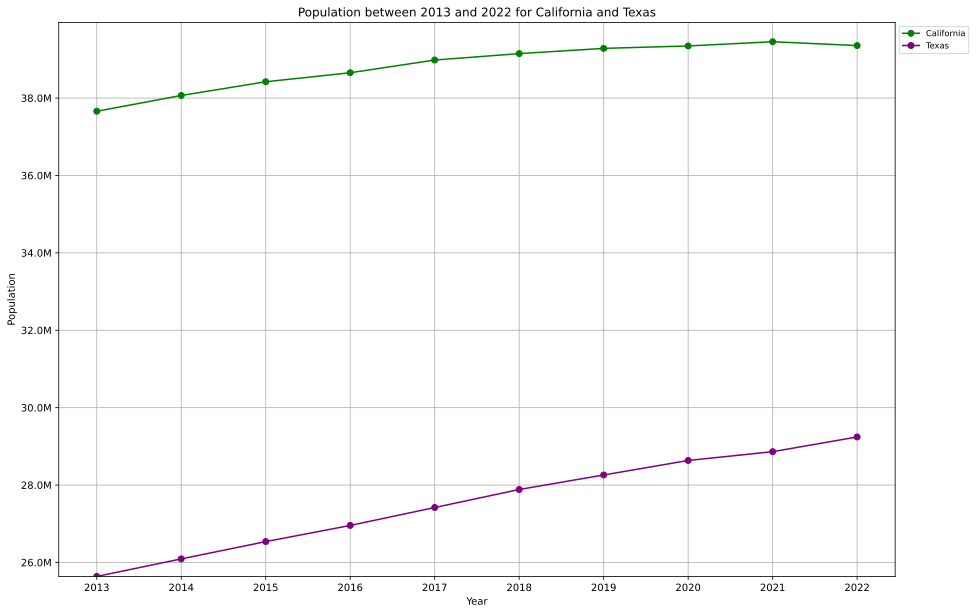

In [6]:
plt.figure(figsize=(15, 10))

colors = {
    'California': COLOR1,
    'Texas': COLOR2
}

for state in ca_tx_data.index:
    population = data.loc[state]
    plt.plot(population.index, population, marker='o', label=state, color=colors[state])

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
plt.ylim(y_min, y_max + 500000)
plt.title('Population between 2013 and 2022 for California and Texas')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
%matplotlib inline
plt.show()

In [7]:
from matplotlib.patches import FancyBboxPatch
from typing import NamedTuple
import matplotlib.patches as patches
from matplotlib.lines import Line2D

class FillData(NamedTuple):
    year1: str
    year2: str
    zscore1: float
    zscore2: float
    change1: float
    change2: float
    middle_x: float
    middle_y: float

def zscore(change):
    """Calculate the zscore of a change."""
    return (change - change.mean()) / change.std()

def get_fill_data(year_idx, change1, change2, zscore1, zscore2):
    """Get data needed for plot_fill(...) and fill(...)"""
    year1, year2 = change1.index[i], change1.index[i + 1]
    zscore_change1 = zscore1.iloc[i + 1] - zscore1.iloc[i]
    zscore_change2 = zscore2.iloc[i + 1] - zscore2.iloc[i]
    middle_x = (year_idx + year_idx + 1) / 2
    middle_y = (zscore1.iloc[i] + zscore1.iloc[i + 1]) / 2

    return FillData(year1, year2, zscore1, zscore2, zscore_change1, zscore_change2, middle_x, middle_y)

def plot_fill(change1: float, change2: float, fill_data: FillData, color1: str = COLOR1, color2: str = COLOR2):
    """Draws the plot for fill data between fill_data.year1 and fill_data.year2"""

    if change1 < 0 and change2 < 0:  # Both changes are declining
        if abs(change1) > abs(change2):  # First change declines more
            fill(fill_data, color1, ('↓', color1), ('↓', color2), 0.5)
        else:  # Second change declines more
            fill(fill_data, color2, ('↓', color1), ('↓', color2), 0.5)
    elif change1 > 0 and change2 > 0:  # Both changes are growing
        if abs(change1) < abs(change2):  # Change1 grows less
            fill(fill_data, color2, ('↑', color1), ('↑', color2), 0.1)
        else:  # Change2 grows less
            fill(fill_data, color2, ('↑', color1), ('↑', color2), 0.1)
    else:  # One is growing, the other is declining
        change1_arrow = '↓' if change1 < 0 else '↑'
        change2_arrow = '↓' if change2 < 0 else '↑'
        if change1 < change2:  # Change1 declines more or grows less
            fill(fill_data, color1, (change1_arrow, color1), (change2_arrow, color2), 0.5)
        else:  # Change 2 declines more or grows less
            fill(fill_data, color2, (change1_arrow, color1), (change2_arrow, color2), 0.5)

def fill(
    fill_data: FillData,
    color: str,
    arrow_left: tuple[str, str],
    arrow_right: tuple[str, str],
    alpha: float
):
    """Fills the space between fill_data.year1 and fill_data.year2"""

    plt.fill_between([fill_data.year1, fill_data.year2],
                    fill_data.zscore1.iloc[i:i + 2], fill_data.zscore2.iloc[i:i + 2],
                    facecolor=color, alpha=alpha)

    middle_x = fill_data.middle_x
    middle_y = fill_data.middle_y

    plt.gca().add_patch(FancyBboxPatch((middle_x - 0.10, middle_y - 0.05), 0.1, 0.1,
                                           boxstyle="round,pad=0.01", facecolor='white', edgecolor='none', zorder=2))
    plt.gca().add_patch(FancyBboxPatch((middle_x + 0.0, middle_y - 0.05), 0.1, 0.1,
                                           boxstyle="round,pad=0.01", facecolor='white', edgecolor='none', zorder=2))
    
    plt.annotate(
        arrow_left[0],
        xy=(middle_x-0.05, middle_y),
        ha='center',
        va='center',
        color=arrow_left[1],
        fontsize=12
    )
    plt.annotate(
        arrow_right[0],
        xy=(middle_x+0.05, middle_y),
        ha='center',
        va='center',
        color=arrow_right[1],
        fontsize=12
    )

def draw_legend(line1_name: str, line2_name: str):
    line_handles = [
        Line2D([0], [0], color=COLOR1, marker='o', linestyle='-', label=f'{" " * 10}{line1_name}'),
        Line2D([0], [0], color=COLOR2, marker='o', linestyle='-', label=f'{" " * 10}{line2_name}')
    ]
    arrow_handles = [
        Line2D([0], [0], color='none', marker='', linestyle='', label=f'↑{" " * 7}Mean-relative growth rate increase'),
        Line2D([0], [0], color='none', marker='', linestyle='', label=f'↓{" " * 7}Mean-relative growth rate decrease')
    ]
    block_handles = [
        patches.Patch(color=COLOR1, alpha=0.25, label=f'{" " * 9}Lower {line1_name} rate increase'),
        patches.Patch(color=COLOR2, alpha=0.25, label=f'{" " * 9}Lower {line2_name} rate increase'),
        patches.Patch(color=COLOR1, alpha=0.8, label=f'{" " * 9}Higher {line1_name} rate decrease'),
        patches.Patch(color=COLOR2, alpha=0.8, label=f'{" " * 9}Higher {line2_name} rate decrease')
    ]
    plt.legend(handles=line_handles + arrow_handles + block_handles, handletextpad=-1.4, loc='lower center').get_frame().set_alpha(1)

In [8]:
year_over_year_change = data.pct_change(axis=1) * 100
year_over_year_change = year_over_year_change.fillna(0)

california_change = year_over_year_change.loc['California']
texas_change = year_over_year_change.loc['Texas']
average_change = year_over_year_change.drop('California').mean()
california_zscore = zscore(california_change)
texas_zscore = zscore(texas_change)
average_zscore = zscore(average_change)

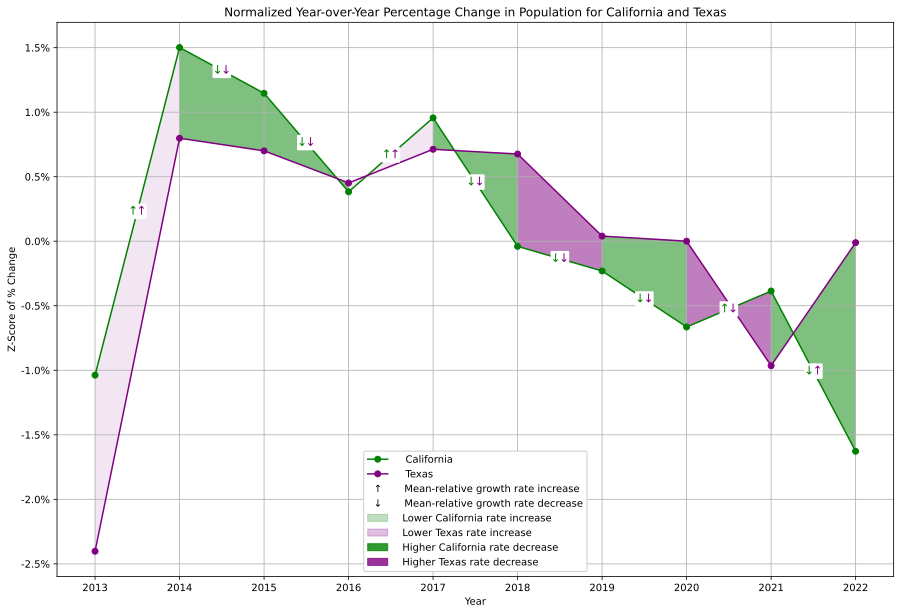

In [9]:
plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.plot(california_change.index, california_zscore, marker='o', label='California', color=COLOR1)
plt.plot(texas_change.index, texas_zscore, marker='o', label='Texas', color=COLOR2)

for i in range(len(california_zscore) - 1):
    fill_data = get_fill_data(i, california_change, texas_change, california_zscore, texas_zscore)
    ca_change = fill_data.change1
    tx_change = fill_data.change2
    plot_fill(ca_change, tx_change, fill_data)

plt.title('Normalized Year-over-Year Percentage Change in Population for California and Texas')
plt.xlabel('Year')
plt.ylabel('Z-Score of % Change')
draw_legend('California', 'Texas')
plt.grid(True)
%matplotlib inline
plt.show()


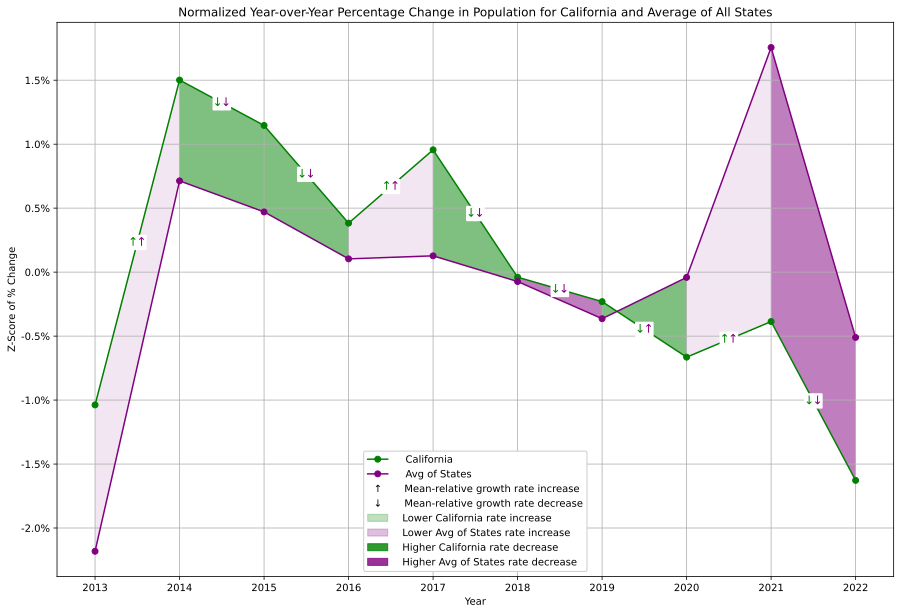

In [10]:
color1 = 'green'
color2 = 'purple'
plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.plot(california_change.index, california_zscore, marker='o', label='California', color=COLOR1)
plt.plot(average_change.index, average_zscore, marker='o', label='Average of All States', color=COLOR2)

for i in range(len(california_zscore) - 1):
    fill_data = get_fill_data(i, california_change, average_change, california_zscore, average_zscore)
    ca_change = fill_data.change1
    avg_change = fill_data.change2
    plot_fill(ca_change, avg_change, fill_data)

plt.title('Normalized Year-over-Year Percentage Change in Population for California and Average of All States')
plt.xlabel('Year')
plt.ylabel('Z-Score of % Change')
draw_legend('California', 'Avg of States')
plt.grid(True)
%matplotlib inline
plt.show()

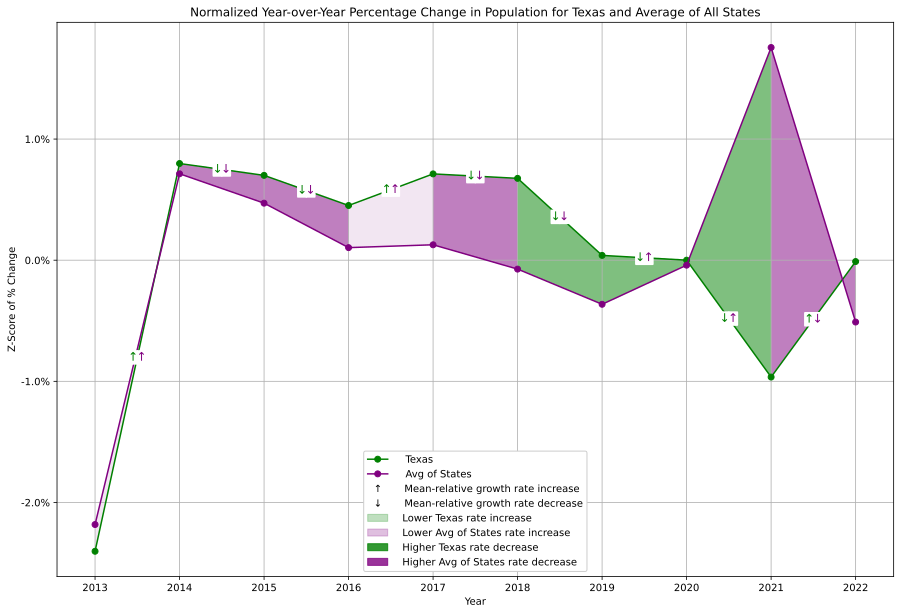

In [11]:
color1 = 'green'
color2 = 'purple'
plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.plot(texas_change.index, texas_zscore, marker='o', label='Texas', color=COLOR1)
plt.plot(average_change.index, average_zscore, marker='o', label='Average of All States', color=COLOR2)

for i in range(len(texas_zscore) - 1):
    fill_data = get_fill_data(i, texas_change, average_change, texas_zscore, average_zscore)
    tx_change = fill_data.change1
    avg_change = fill_data.change2
    plot_fill(tx_change, avg_change, fill_data)

plt.title('Normalized Year-over-Year Percentage Change in Population for Texas and Average of All States')
plt.xlabel('Year')
plt.ylabel('Z-Score of % Change')
draw_legend('Texas', 'Avg of States')
plt.grid(True)
%matplotlib inline
plt.show()

In [12]:
pop_2013_sorted = data['2013'].sort_values(ascending=False)
pop_2022_sorted = data['2022'].sort_values(ascending=False)

order_2013 = pop_2013_sorted.index.tolist()
order_2022 = pop_2022_sorted.index.tolist()

changed_states = [state for state in order_2013 if order_2013.index(state) != order_2022.index(state)]
position_change = {state: abs(order_2013.index(state) - order_2022.index(state)) for state in order_2013}
sorted_position_change = sorted(position_change.items(), key=lambda x: x[1], reverse=True)
top_3_states_by_position_change = [state for state, change in sorted_position_change[:3]]
bottom_3_states_by_position_change = [state for state, change in sorted_position_change if change > 0][-3:]

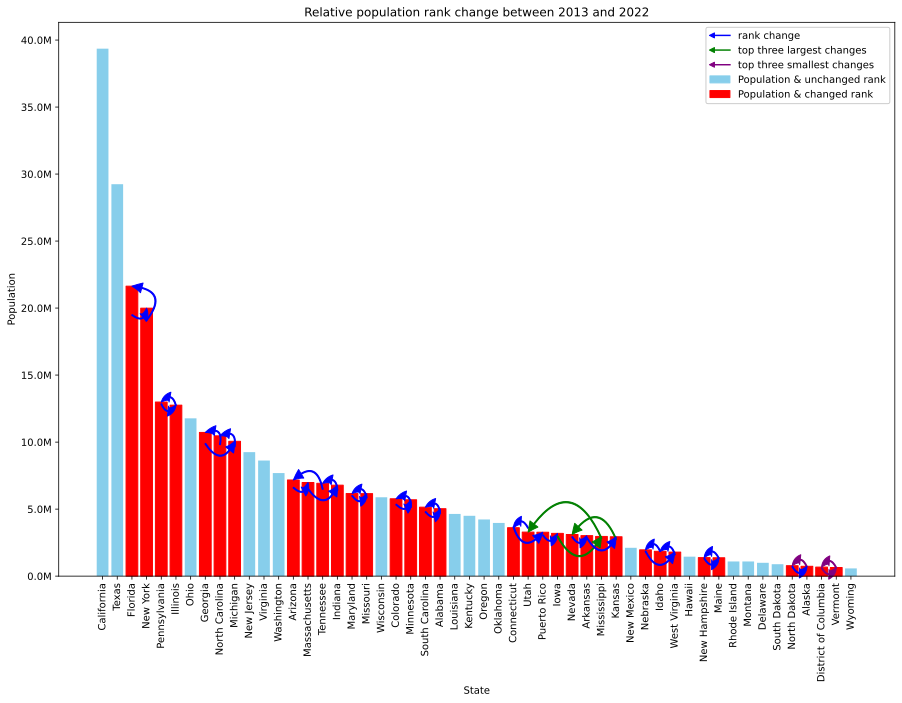

In [57]:
from matplotlib.patches import ConnectionPatch, ArrowStyle
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D

class HandlerArrowLine(HandlerLine2D):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a line and an arrowhead as separate artists
        padding = 2
        line = Line2D([xdescent + padding, width - xdescent], [height / 2, height / 2], linestyle=orig_handle.get_linestyle(), color=orig_handle.get_color())
        arrow = Line2D([xdescent + padding], [height / 2], marker='<', color=orig_handle.get_color(), markersize=fontsize / 2, linestyle='None')
        return [line, arrow]

plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
bars_2022 = plt.bar(pop_2022_sorted.index, pop_2022_sorted, color=COLOR5)
plt.title('Relative population rank change between 2013 and 2022')
plt.xlabel('State')
plt.ylabel('Population')
plt.xticks(rotation=90)
line_handles = [
    Line2D([0], [1], color=COLOR3, marker='<', linestyle='-', label='rank change'),
    Line2D([0], [1], color=COLOR1, marker='<', linestyle='-', label='top three largest rank changes'),
    Line2D([0], [1], color=COLOR2, marker='<', linestyle='-', label='top three smallest rank changes'),
]
block_handles = [
    patches.Patch(color=COLOR5, label='Population & unchanged rank'),
    patches.Patch(color=COLOR4, label='Population & changed rank')
]
plt.legend(handles=line_handles + block_handles,  handler_map={handle: HandlerArrowLine() for handle in line_handles}).get_frame().set_alpha(1)

ax = plt.gca()
for bar, state in zip(bars_2022, pop_2022_sorted.index):
    if state in changed_states:
        bar.set_color(COLOR4)
        prev_pos = order_2013.index(state)
        new_pos = order_2022.index(state)
        con = ConnectionPatch(
            xyA=(prev_pos, pop_2013_sorted[state]),
            xyB=(new_pos, pop_2022_sorted[state]),
            coordsA="data", coordsB="data",
            axesA=ax, axesB=ax,
            color=COLOR1 if state in top_3_states_by_position_change else (COLOR2 if state in bottom_3_states_by_position_change else COLOR3),
            arrowstyle=ArrowStyle("simple", head_width=1, head_length=1, tail_width=0.1), 
            fill=True,
            linewidth=1,
            connectionstyle="arc3,rad=0.9"
        )
        ax.add_patch(con)
%matplotlib inline
plt.show()

In [14]:
year_over_year_change = (data.pct_change(axis=1) * 100).iloc[:, 1:]
average_annual_rate_of_change = year_over_year_change.mean(axis=1)
average_annual_rate_of_change_sorted = average_annual_rate_of_change.sort_values(ascending=False)

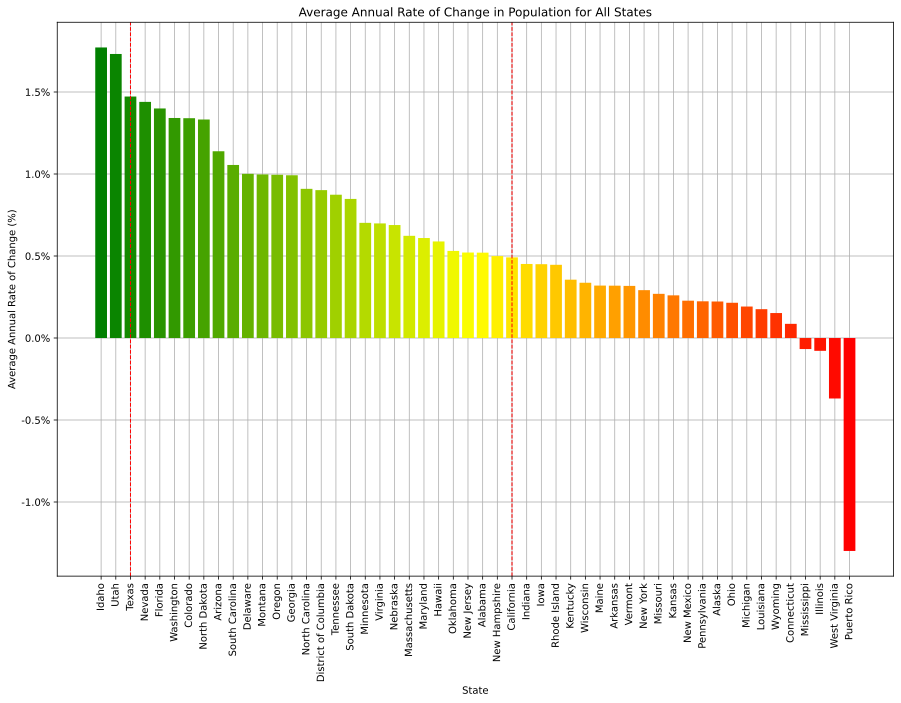

In [15]:
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create a gradient color map from green to yellow to red
colors = ["green", "yellow", "red"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Normalize to show relative percentage change
norm = plt.Normalize(0, len(average_annual_rate_of_change_sorted) - 1)
plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
bars = plt.bar(
    average_annual_rate_of_change_sorted.index,
    average_annual_rate_of_change_sorted,
    color=[cmap(norm(i)) for i in range(len(average_annual_rate_of_change_sorted))],
    zorder=2 # hide grid behind bars
)

ax = plt.gca()
for state in ['California', 'Texas']:
    idx = average_annual_rate_of_change_sorted.index.get_loc(state)
    bar = bars[idx]
    x = bar.get_x() + bar.get_width() / 2
    ax.axvline(x=x, color='red', linestyle='--', linewidth=1)

plt.title('Average Annual Rate of Change in Population for All States')
plt.xlabel('State')
plt.ylabel('Average Annual Rate of Change (%)')
plt.xticks(rotation=90)
plt.grid(True, zorder=0) # hide grid behind bars
%matplotlib inline
plt.show()